#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [15]:
!which python

/home/tobi/anaconda3/envs/Assignment5/bin/python


# Install dependencies:

In [16]:
install_packages = True
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



# Imports

In [5]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [6]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [7]:
# Set pandas print options
This will improve readability of printed pandas dataframe.


SyntaxError: invalid syntax (<ipython-input-7-804d46c41beb>, line 2)

In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [10]:
output_path = "./Documents/FU Berlin/CSMA/Assignment 5/output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [11]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [12]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [13]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 50 silhouette_avg: 0.30361533
n_clusters: 51 silhouette_avg: 0.30610773
n_clusters: 52 silhouette_avg: 0.29980668
n_clusters: 53 silhouette_avg: 0.3028828
n_clusters: 54 silhouette_avg: 0.3060633
n_clusters: 55 silhouette_avg: 0.30093178
n_clusters: 56 silhouette_avg: 0.29926574
n_clusters: 57 silhouette_avg: 0.29940543
n_clusters: 58 silhouette_avg: 0.3019507
n_clusters: 59 silhouette_avg: 0.30399972
n_clusters: 60 silhouette_avg: 0.30706248
n_clusters: 61 silhouette_avg: 0.31008652
n_clusters: 62 silhouette_avg: 0.31203592
n_clusters: 63 silhouette_avg: 0.31325105
n_clusters: 64 silhouette_avg: 0.30719495
n_clusters: 65 silhouette_avg: 0.29878914
n_clusters: 66 silhouette_avg: 0.3003629
n_clusters: 67 silhouette_avg: 0.29761344
n_clusters: 68 silhouette_avg: 0.29814306
n_clusters: 69 silhouette_avg: 0.30046904


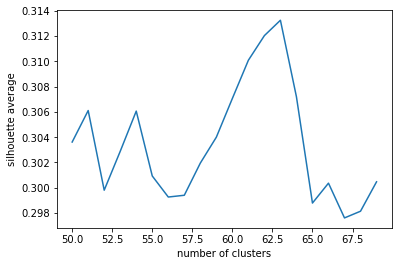

In [16]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=50 
max_clusters=70
step=1

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [17]:
number_of_clusters =  63
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 47     2
51     5
48     6
59     6
52     7
23     8
31     9
37    10
20    10
56    11
45    11
34    11
54    11
9     12
57    12
4     12
21    12
42    12
40    12
60    13
62    13
11    13
58    14
41    15
10    15
38    15
0     15
17    15
49    16
6     17
46    18
43    18
13    18
14    19
61    19
27    20
32    21
29    21
24    22
30    22
26    22
53    23
35    23
19    25
5     27
3     28
36    28
44    29
8     30
28    30
7     31
25    32
33    32
39    34
16    34
12    37
55    41
1     41
50    42
15    42
18    43
22    58
2     67
Name: label_kmedoids, dtype: int64


In [18]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [19]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer.fit_transform(embeddings)

# Visualize clustering results

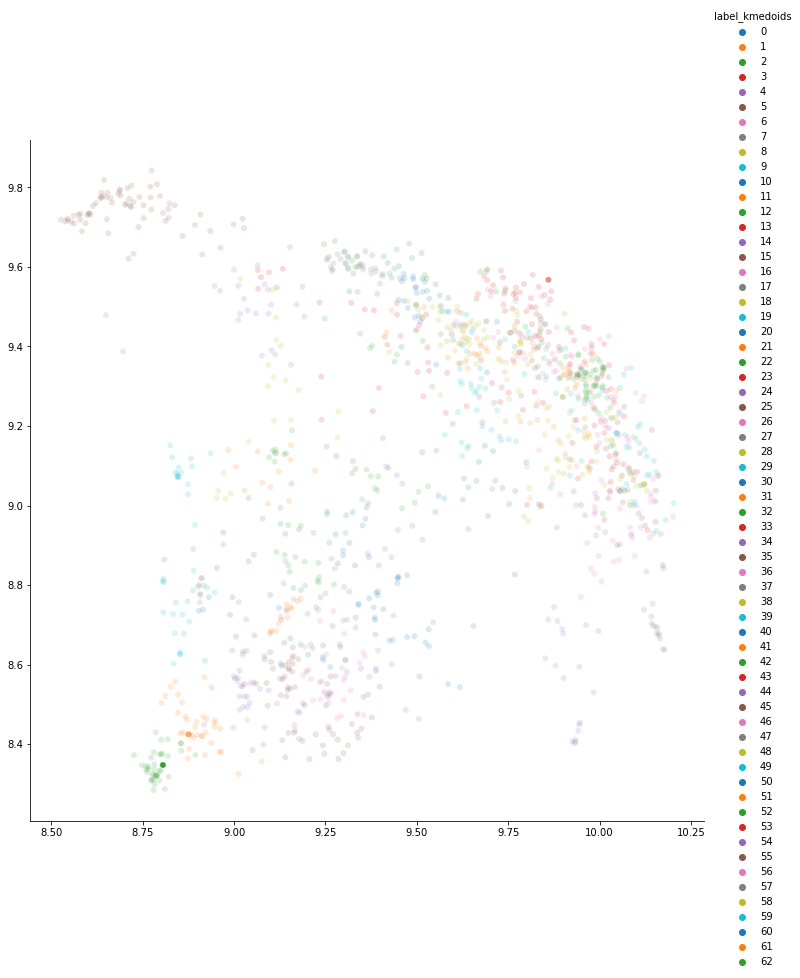

In [20]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "tab10" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

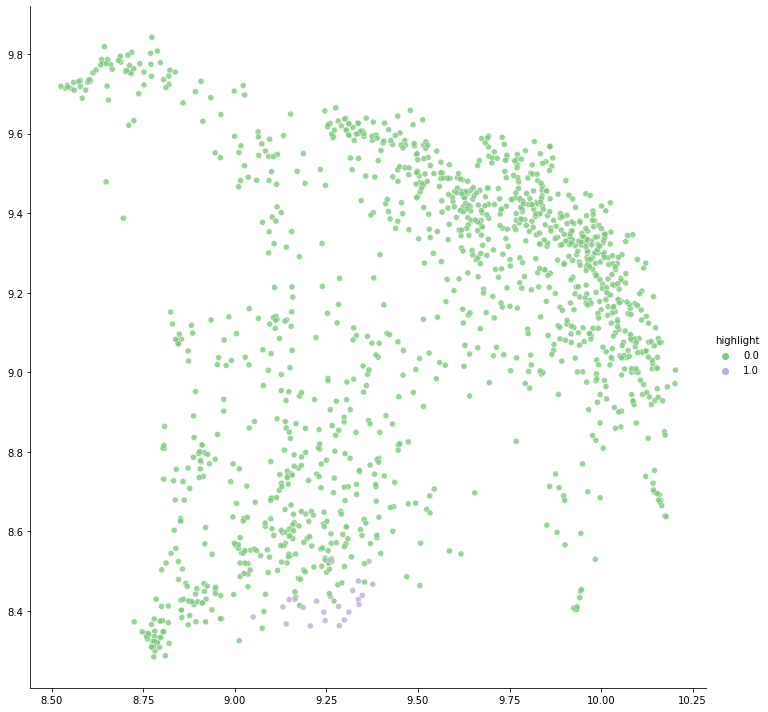

In [30]:
## Choose a cluster to higlight:
cluster_num = 35

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [31]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1290,2019-08-21 14:15:48,Jockum T,@sb As much as I'd like to have a laugh when you give me your sources I'm just gonna tell you to get a relevant university degree. That will help you understand climate change,1,@sb As much as I'd like to have a laugh when you give me your sources I'm just\ngonna tell you to get a relevant university degree. That help you\nunderstand climate change\n\n,-1.0,0,1.788139e-07,0.0
133,2020-04-04 13:49:39,KelliAnn Winkler,@Evan Scammell Well DUH!!,1,@ Well DUH!!\n\n,-1.0,1,0.000000e+00,0.0
125,2020-04-05 03:49:30,Evan Scammell,@KelliAnn Winkler I just explained other causes besides Co2 so if you mind reading my comments that would be much appriciated,1,@ I just explained other causes besides Co2 so if you mind\nreading my comments that would be much appriciated\n\n,-1.0,2,0.000000e+00,0.0
589,2019-10-31 17:12:28,Rick TD,"When you use the term ""climate change denier"" you expose yourself as someone brainwashed by the elites to think the way they want you to think and repeat what they say like a parrot.",1,"When you use the term ""climate change denier"" you expose yourself as someone\nbrainwashed by the elites to think the way they want you to think and repeat\nwhat they say like a parrot.\n\n",-1.0,3,4.768372e-07,0.0
767,2019-09-12 03:26:38,Merlinite,@Angela Tester I'm Aussie we got all type of murder torpedoes here,1,@ I'm Aussie we got all type of murder torpedoes here\n\n,-1.0,4,0.000000e+00,0.0
608,2019-08-28 15:42:55,Martin Ulstein,Bill Nye is a criminal and a liar working for the deep state. There is no man made climate change. What a pack of lies.,0,Bill Nye is a criminal and a liar working for the deep state. There is no man\nmade climate change. What a pack of lies.\n\n,-1.0,5,0.000000e+00,0.0
1127,2019-11-21 03:45:40,Alex Gahala,"@Black Sheep You cannot evolve that fast. Plus there will be days where you can't even go outside it will be so hot! But, At least you acknowledge that it is a thing, I'll give you that.",1,"@ You cannot evolve that fast. Plus there be days where you\ncan't even go outside it be so hot! But, At least you acknowledge that it\nis a thing, I'll give you that.\n\n",-1.0,6,0.000000e+00,0.0
563,2019-09-03 03:26:49,Lawrence Smith,"Ignorance indeed.<br />It is our Sun, according to Valentina Zharkova, a russian mathematician and Astrophysicist.<br />Zharkova used Nasa data to predict, with a 97% rate of accuracy, our changing suns state over the last 10 years.<br />The Sun is entering in to its lowest point of dynamic magnetic field strength in hundreds of years.<br />Thats huge......why?<br />The suns lowered magnetic field strength in turn weakens our Magnetosphere because it originates from the sun.<br />The Magnetosphere naturally shelters the entire Solar System from Galactic energy originating from space.<br />An increase of 40-50% more radiation has been documented entering our atmosphere since 2014.<br />This radiation is heating our land, air and water.<br />As oceans warm they force the release of CO2 and other Green house gases from dissolved suspension, basic science and something Bill Nye should be able to grasp, even without a chart.<br />Glacial ice samples reveal climate has always changed naturally.<br />The samples also show temperature always increase before CO2 increases ( see step 1)<br />CO2 increase is a symptom of warming, not the driver.<br />To illustrate another aspect of this issue, a show host in Australia was speaking to a member of the IPCC.<br />Wanting to Confirm some basic climate numbers:<br />CO2 is less than .04 of 1% of our atmosphere? - Yes<br />CO2 created by humans is .03 of this - Yes<br />Australians are responsible for 1.5% of the .03% of the .04 of 1% - Yes you are right.<br />So, our atmosphere contains 415 ppm of CO2 of which Australians are responsible for approx .22 of 1 ppm of the 415 ppm.<br />After leaving, this same IPC

In [32]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  15 mean distance from center:  0.0023825963580748066 Proportion of replies: 100.0
1 number of samples:  41 mean distance from center:  0.0013428490092337597 Proportion of replies: 87.8048780487805
2 number of samples:  67 mean distance from center:  0.002410963315924164 Proportion of replies: 89.55223880597015
3 number of samples:  28 mean distance from center:  0.0015648347471142188 Proportion of replies: 35.714285714285715
4 number of samples:  12 mean distance from center:  0.002942979335784912 Proportion of replies: 83.33333333333333
5 number of samples:  27 mean distance from center:  0.0011671472748275846 Proportion of replies: 33.333333333333336
6 number of samples:  17 mean distance from center:  0.002398911601630971 Proportion of replies: 88.23529411764706
7 number of samples:  31 mean distance from center:  0.0005912396318308311 Proportion of replies: 83.87096774193549
8 number of samples:  30 mean distance from center:  0.0019659599274746142 Proportion 

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [33]:
# Choose a cluster to print
cluster_number =   35
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 23
Average Distance from cluster center: 2.2465769e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
772,2019-08-21 16:28:04,Natalie Watkins,Wait what happens in 2031?,0,Wait what happens in 2031?\n\n,-1.0,35,0.000000,1.0
506,2020-01-15 10:42:52,Barton Paul Levenson,@Meta Tegra I don't even know what NRPing is.,1,@ I don't even know what NRPing is.\n\n,-1.0,35,0.000005,1.0
47,2020-08-07 23:56:19,Vic_tory,"@Tony wait response for what, i never got a notification.",1,"@ wait response for what, i never got a notification.\n\n",-1.0,35,0.000005,1.0
1187,2019-11-08 23:46:18,Bigboys,@Rick TD I don't know the answer so I sighted out a paper https://scied.ucar.edu/carbon-dioxide-absorbs-and-re-emits-infrared-radiation,1,@ I don't know the answer so I sighted out a paper\n\n\n,-1.0,35,0.000009,1.0
708,2019-09-15 01:35:46,John David,@Existential Intellectual So what are these plans and how're we to execute them?,1,@ So what are these plans and how're we to execute\nthem?\n\n,-1.0,35,0.000009,1.0
510,2020-01-15 02:42:02,Meta Tegra,@Barton Paul Levenson See what I mean about NRPing. You are always NRPing away aren't you.,1,@ See what I mean about NRPing. You are always NRPing away\naren't you.\n\n,-1.0,35,0.000011,1.0
1055,2019-11-18 20:19:03,Alex Gahala,@Rick TD So all those people are lying to you. You know how hard it would be to organize that?,1,@ So all those people are lying to you. You know how hard it would be\nto organize that?\n\n,-1.0,35,0.000017,1.0
939,2019-10-21 08:35:04,Tezuka,@TheFlashFinn So you just basically go away? LOL how incompetent,1,@ So you just basically go away? LOL how incompetent\n\n,-1.0,35,0.000017,1.0
1198,2019-10-27 20:57:57,Iown291,"@Rick TD What do acronyms have to do with anything, lol",1,"@ What do acronyms have to do with anything, lol\n\n",-1.0,35,0.000019,1.0
400,2019-10-12 22:55:08,MagicForDummiez,"@Forte3645 So basically you bunched so many different things as ""the left"". Understandable.",1,"@ So basically you bunched so many different things as ""the left"".\nUnderstandable.\n\n",-1.0,35,0.000021,1.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [ ]:
#which cluster would you like to assign labels to?
cluster_number = 18
#your label
label_manual = 'music'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [ ]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')